In [ ]:
#default_exp noisyimagenette

In [ ]:
#hide
!pip install nbdev -q --upgrade
!pip install fastai -q --upgrade

In [ ]:
!pip install wwf -q --upgrade
!pip install cleanlab -q --upgrade

In [ ]:
from fastcore.test import *

import fastai, fastcore, nbdev, wwf
test_eq(['2.3.1', '1.3.20', '1.1.14'], [fastai.__version__, fastcore.__version__, nbdev.__version__])

In [ ]:
from wwf.utils import *
state_versions([fastai, fastcore, nbdev, wwf])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, `nbdev`, and `wwf` currently running at the time of writing this:
* `fastai` : 2.3.1 
* `fastcore` : 1.3.20 
* `nbdev` : 1.1.14 
* `wwf` : 0.0.14 
---

In [ ]:
#export 
from fastai.vision.all import *
from pathlib import Path

import pandas as pd

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
set_seed(42, reproducible=True)
source = untar_data(URLs.IMAGENETTE)
df: pd.DataFrame = pd.read_csv(source/'noisy_imagenette.csv')

train_df = df[df.is_valid == False]

In [ ]:
test_eq(9469, len(train_df))
test_eq(13394, len(df))

expected = ['path', 'noisy_labels_0', 'noisy_labels_1', 'noisy_labels_5', 'noisy_labels_25', 'noisy_labels_50', 'is_valid']
test_eq(expected, list(df))
test_eq(3925, len(df[df['is_valid'] == True]))

sample = dict(
    is_valid=False,
    noisy_labels_0='n02979186',
    noisy_labels_1='n02979186',
    noisy_labels_25='n02979186',
    noisy_labels_5='n02979186',
    noisy_labels_50='n02979186',
    path='train/n02979186/n02979186_9036.JPEG')
test_eq(sample, dict(df.iloc[0]))

In [ ]:
#export
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)
lbl_dict_inv = {v: k for k, v in lbl_dict.items()}
def get_inverse_transform(vocab):
  return L(vocab).map(lbl_dict_inv)

In [ ]:
#export
def get_dls(file, noice_pct=5, size=128, soft_targets=False):

  if soft_targets:
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_x=ColReader('path', pref=source),
                    get_y=Pipeline([ColReader(f'soft_targets'), lbl_dict.__getitem__]),
                    splitter=ColSplitter(), #uses the bool value in is_valid column on the dataframe to identify the validation set (without any noise).
                    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                    batch_tfms=Normalize.from_stats(*imagenet_stats))

  else: 
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_x=ColReader('path', pref=source),
                    get_y=Pipeline([ColReader(f'noisy_labels_{noice_pct}'), lbl_dict.__getitem__]),
                    splitter=ColSplitter(), #uses the bool value in is_valid column on the dataframe to identify the validation set (without any noise).
                    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                    batch_tfms=Normalize.from_stats(*imagenet_stats))
  dls = dblock.dataloaders(file)
  return dls

## 1 noice percent

In [ ]:
len(train_df), (train_df.noisy_labels_0 == train_df.noisy_labels_1).sum(), (train_df.noisy_labels_0 != train_df.noisy_labels_1).sum()

(9469, 9374, 95)

In [ ]:
expected_noisy_indices = train_df[(train_df.noisy_labels_0 != train_df.noisy_labels_1)].index.values; expected_noisy_indices

array([ 106,  251,  315,  457,  483,  582,  592,  683,  747,  765,  774,
        782,  908,  932, 1056, 1087, 1217, 1626, 1650, 1888, 1928, 1945,
       2149, 2183, 2210, 2362, 2522, 2523, 2526, 3019, 3126, 3146, 3381,
       3418, 3577, 3639, 3772, 3798, 3945, 3995, 4002, 4139, 4354, 4513,
       4838, 4925, 5014, 5204, 5327, 5344, 5771, 5828, 6051, 6177, 6189,
       6310, 6343, 6440, 6551, 6553, 6578, 6673, 6909, 7001, 7065, 7092,
       7109, 7132, 7290, 7593, 7615, 7689, 7707, 7724, 7758, 7807, 7821,
       7854, 7895, 7923, 8218, 8231, 8250, 8285, 8294, 8336, 8367, 8377,
       8537, 8606, 8687, 8846, 8948, 9035, 9234])

In [ ]:
dls_1 = get_dls(df, 1, size=224)

In [ ]:
#export
learn_1 = cnn_learner(dls_1, resnet18, metrics=[accuracy, RocAuc()])

In [ ]:
learn_1.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.363759,0.062120,0.981147,0.999702,01:40


In [ ]:
import gc
gc.collect()

64

## Remove the inputs from Interpretation & get the indices of top label errors in the dataset.

In [ ]:
from cleanlab.pruning import get_noise_indices

@patch_to(Interpretation)
def top_label_errors(self, k=None):
    idxs = get_noise_indices(s=self.targs.numpy(), #noisy targets
                            psx=self.preds.numpy(),#predictions_prob
                            sorted_index_method='normalized_margin',
                            prune_method='both',
                            n_jobs=1) #disable parallel processing
    return L(listify(idxs, use_list=True))

@patch_to(Interpretation, cls_method=True)
def from_learner(cls, learn, ds_idx=1, dl=None, act=None, with_input=False):
    "Construct interpretation object from a learner without saving the inputs"
    if dl is None: dl = learn.dls[ds_idx].new(shuffled=False, drop_last=False)
    return cls(dl, None, *learn.get_preds(dl=dl, with_input=with_input, with_loss=True, with_decoded=True, act=None))

interp = Interpretation.from_learner(learn_1, ds_idx=0, with_input=False)
train_ordered_label_errors = interp.top_label_errors()

In [ ]:
train_ordered_label_errors

(#89) [4838,5327,6440,5204,6551,5014,106,2149,3798,8218...]

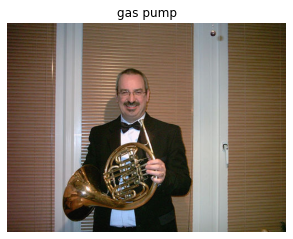

In [ ]:
show_at(learn_1.dls.train_ds, 6440)

In [ ]:
actual = train_ordered_label_errors.sorted()

In [ ]:
exp = L(listify(expected_noisy_indices, use_list=True))

In [ ]:
set(exp) - set(actual)

{315, 457, 483, 582, 932, 3577, 4002, 4139, 4354, 7092, 7615, 7689, 8846, 9035}

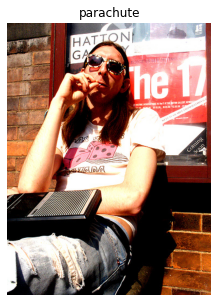

In [ ]:
show_at(learn_1.dls.train_ds,315)

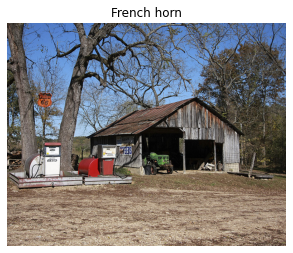

In [ ]:
show_at(learn_1.dls.train_ds,9035)